# Метды SVM и Logistic Regression для классификации текстов

In [120]:
#готовый набор даных
from sklearn import datasets

# хранине данных
import pandas as pd
import numpy as np

# Обучене модели и подготовка данных
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(12,8)})

import warnings
warnings.filterwarnings('ignore') 

#### загружаем дланные

In [2]:
newsgroups = datasets.fetch_20newsgroups(
                    subset='all', 
                    categories=['alt.atheism', 'sci.space']
             )

In [11]:
X = newsgroups.data
y = newsgroups.target

In [18]:
np.bincount(np.array(y))

array([799, 987])

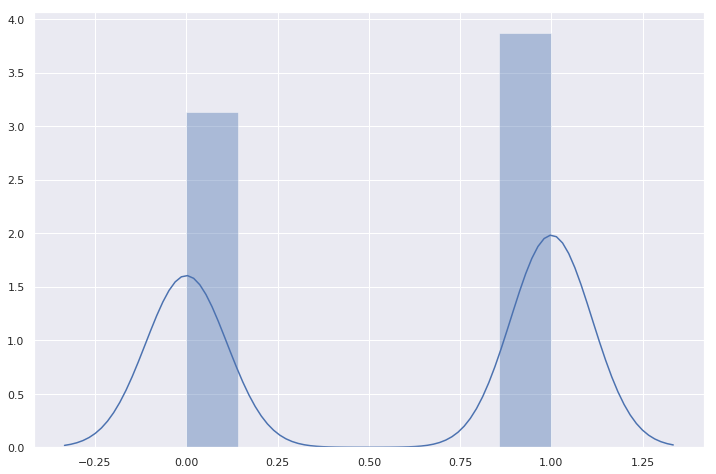

In [12]:
sns.distplot(y)

#### Создание вектора признаков

In [20]:
vectorizer = TfidfVectorizer(max_features = 2000, analyzer='word', lowercase=True, stop_words='english')
X = vectorizer.fit_transform(X)

#### создание сетки для подбора параметров

In [23]:
grid = {'C': np.power(10.0, np.arange(-5, 6))}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
clf = SVC(kernel='linear', random_state=241)
gs = GridSearchCV(clf, grid, scoring='accuracy', cv=cv)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=241,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

#### Получаем оценку качества и значения параметра С

In [40]:
print(gs.cv_results_['mean_test_score'])# — оценка качества по кросс-валидации
print(gs.cv_results_['params'])# — значения параметров

[0.55263158 0.55263158 0.55263158 0.55263158 0.98712206 0.99160134
 0.9893617  0.9893617  0.9893617  0.9893617  0.9893617 ]
[{'C': 1e-05}, {'C': 0.0001}, {'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1.0}, {'C': 10.0}, {'C': 100.0}, {'C': 1000.0}, {'C': 10000.0}, {'C': 100000.0}]


#### Разбиваем обучающий набор на тестовую и обучающую выборку для дальнейшего обучения модели

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Обучаем модель

In [46]:
clf = SVC(kernel='linear', C=1.0, random_state=241)
clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))

0.9915254237288136


#### Создаем Dataframe с двумя столбцами: Значимость признака, токен.
функция zip объединяет два массива, sorted - сортирует их, для отрисовки графика преобразуем типы

In [100]:
data = pd.DataFrame(np.array(sorted(zip(clf.coef_.toarray()[0], vectorizer.get_feature_names()),reverse=True)), 
                    columns=['IMPORTANCE', 'NAME'])
data.IMPORTANCE = data['IMPORTANCE'].astype(np.float64)
data.info()

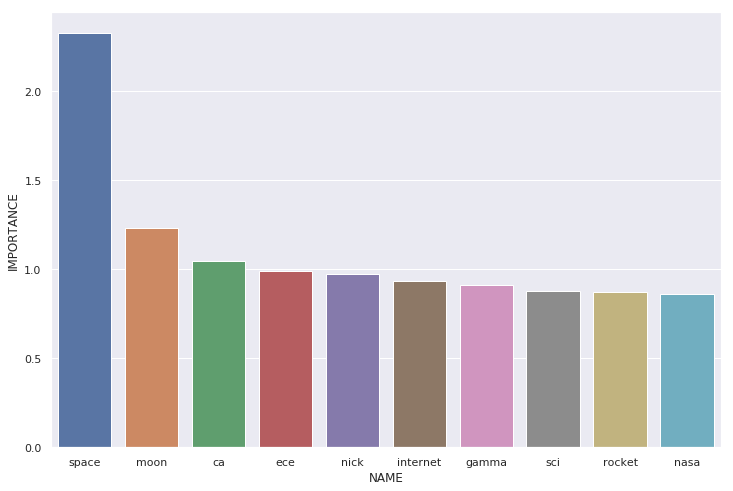

In [103]:
sns.barplot(x='NAME', y='IMPORTANCE', data=data.head(10))

In [107]:
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='auto')
logreg.fit(X_train, y_train)
print(accuracy_score(y_test, logreg.predict(X_test)))

0.9932203389830508


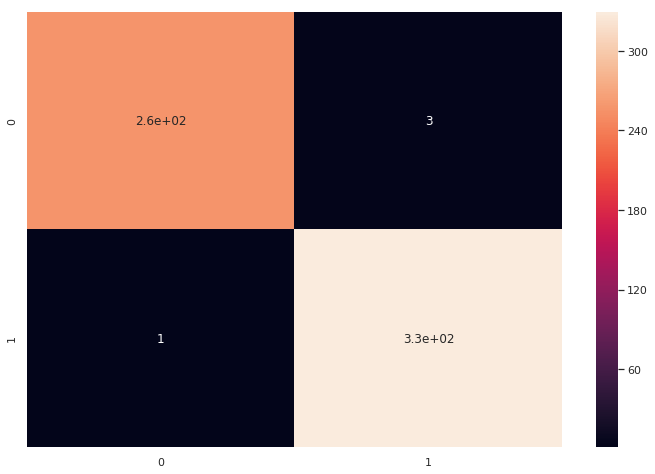

In [125]:
sns.heatmap(confusion_matrix(y_test, logreg.predict(X_test)), annot=True)

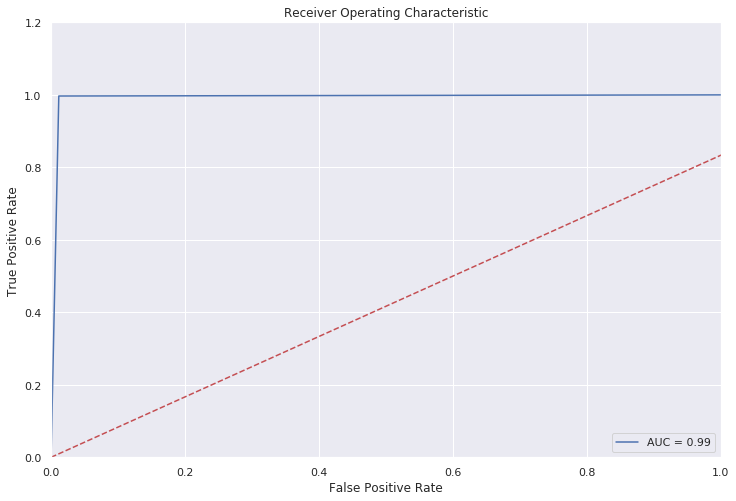

In [123]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict(X_test))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_test, logreg.predict(X_test)))
plt.legend(loc = 'lower right')
plt.plot([0, 1.2], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()